In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

Walkthrough for creating a model 4-Gaussian trace profile on the 2D NIRISS detector. Functions are stored in ModelTraceto2DMap.py

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import UdeMSOSS as soss
from astropy.modeling import models, fitting
from tqdm import tqdm
import ModelTraceto2DMap as mt
import warnings
# import sys
# sys.path.insert(1, '/Users/michaelradica/Documents/GitHub/jwst-mtl/SOSS/trace/')
# import tracepol as tp

warnings.filterwarnings("ignore")

10:80: E501 line too long (82 > 79 characters)


### Create an example rectified trace, with no spectral dependence and random parameters

100%|██████████| 2048/2048 [00:00<00:00, 2210.63it/s]


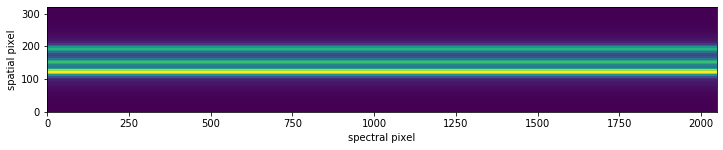

In [15]:
amp, pos, wid = [0.006, 0.006, 0.01, 0.002], [30, 38, 24, 30], \
    [1.6, 1.6, 1.6, 9]  # random 4G parameters
G4mod = mt.construct_model_4G(amp, pos, wid)  # make the 4G model
rectr = mt.make_rectified_trace(G4mod, np.arange(64), os=5)

fig = plt.figure(figsize=(12, 15))
plt.imshow(rectr)
plt.xlabel('spectral pixel')
plt.ylabel('spatial pixel')
plt.gca().invert_yaxis()

### Estimate the spectral dependence of the trace model from CV3 data

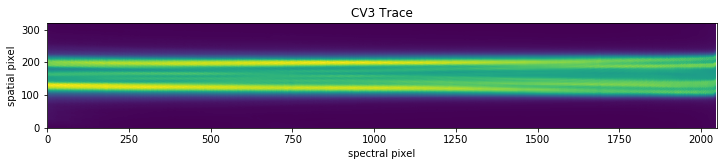

In [17]:
# Empirical trace from CV3 data - for fits
a = fits.open('LoicsWork/InputFiles/trace_order1.fits')
tracemodel_L = a[0].data
tracemodel_L = np.delete(tracemodel_L, 1, axis=0)
osdimy = a[0].header['OVRSAMPY']
semiwidthy = int((np.shape(tracemodel_L)[0] - 1) / osdimy / 2)

fig = plt.figure(figsize=(12, 15))
plt.title('CV3 Trace', fontsize=12)
plt.imshow(tracemodel_L)
plt.xlabel('spectral pixel')
plt.ylabel('spatial pixel')
plt.gca().invert_yaxis()

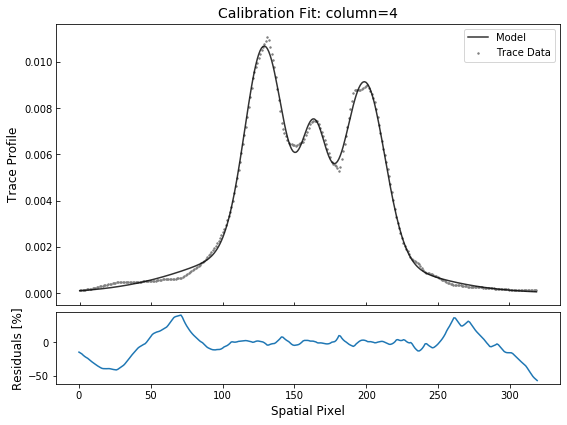

In [18]:
# Calibrate the empirical trace fit
A, M, S = mt.calibratefit(tracemodel_L, plot=True)

100%|██████████| 2040/2040 [06:51<00:00,  4.96it/s]


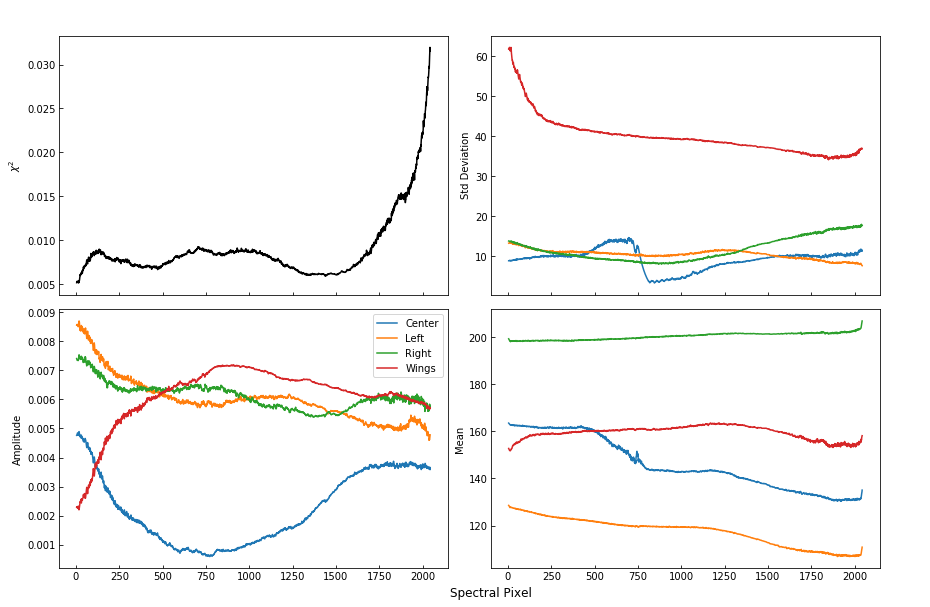

In [19]:
# Fit the 4-Gaussian model to each column in the CV3 trace
specparams = mt.fit_rectrace(tracemodel_L, A, M, S, plot=True)

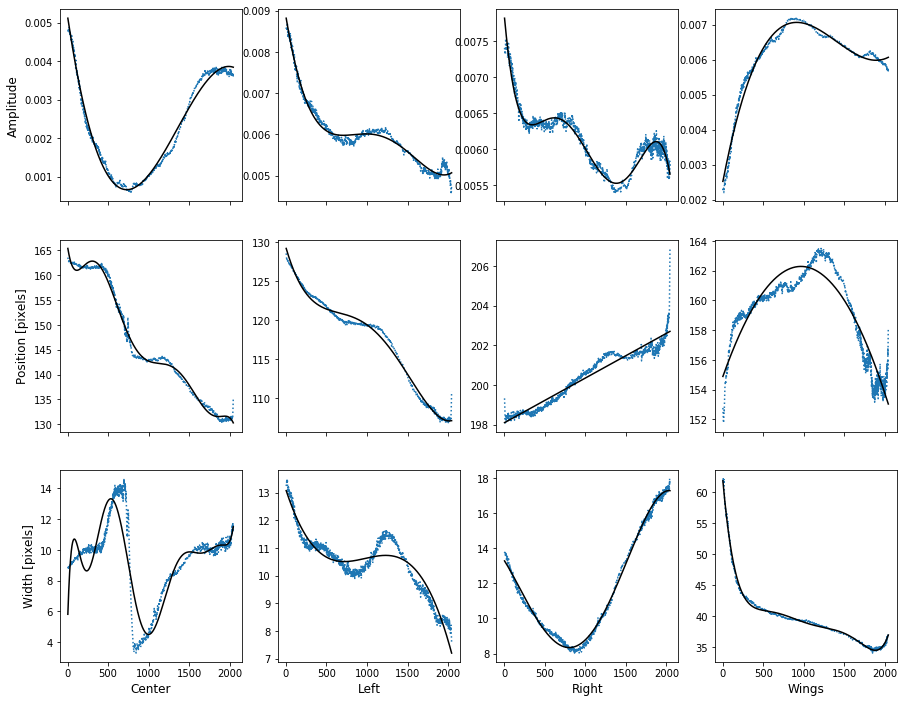

In [20]:
# Fit polynomials to the Gaussian parameter variations
polys = mt.fit_specpoly(specparams, os=5, plot=True)

### Create the new trace model, with spectral dependence

In [24]:
tracemodel_withspec = mt.make_rectified_trace(mt.construct_model_4G,
                                              specparams=polys, os=5)

100%|██████████| 2048/2048 [00:03<00:00, 522.98it/s]


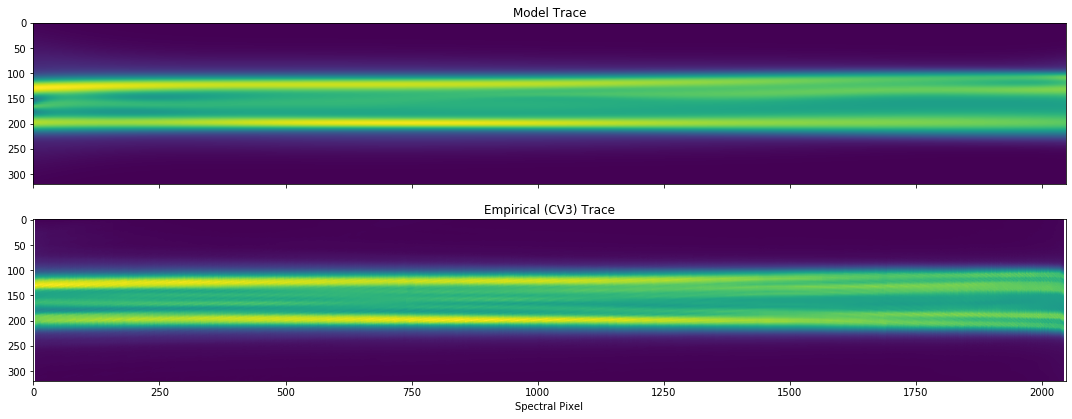

Text(0.5, 1.0, 'Percent Differences')

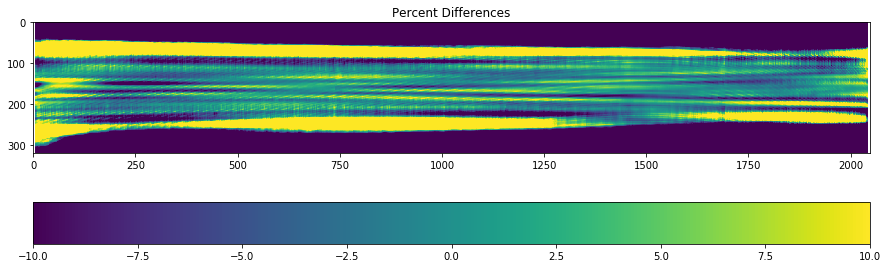

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)
ax[0].set_title('Model Trace')
ax[0].imshow(tracemodel_withspec)

ax[1].imshow(tracemodel_L)
ax[1].set_title('Empirical (CV3) Trace')
ax[1].set_xlabel('Spectral Pixel')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.imshow(100*(tracemodel_withspec - tracemodel_L)/tracemodel_L,
           vmin=-10, vmax=10)
plt.colorbar(orientation="horizontal")
plt.title('Percent Differences')

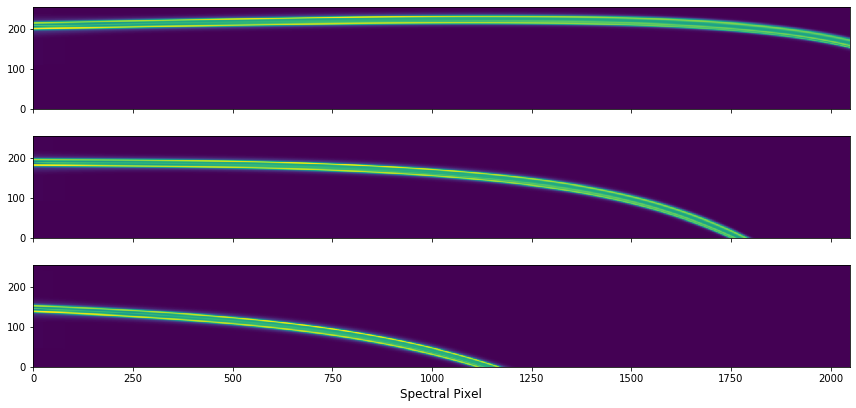

In [28]:
# Example plot of all three orders
ms = [1, 2, 3]
map2D = mt.make_2D_trace(tracemodel_withspec, orders=ms, os=5)
fig, ax = plt.subplots(nrows=len(ms), ncols=1, figsize=(12, 2*len(ms)),
                       sharex=True)
for m in ms:
    ax[m-1].imshow(map2D[m-1], origin='lower')
plt.xlabel('Spectral Pixel', fontsize=12)
fig.tight_layout()